In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2,os
from tqdm.auto import tqdm

In [2]:
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle

In [3]:
import kaggle

In [6]:
!kaggle competitions download -c aerial-cactus-identification

 92% 11.0M/12.0M [00:00<00:00, 41.6MB/s]
100% 12.0M/12.0M [00:00<00:00, 41.6MB/s]


In [7]:
!unzip -q /content/aerial-cactus-identification.zip

In [8]:
!rm -rf /content/aerial-cactus-identification.zip

In [5]:
data = pd.read_csv('/content/train.csv')

In [6]:
data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


<Axes: >

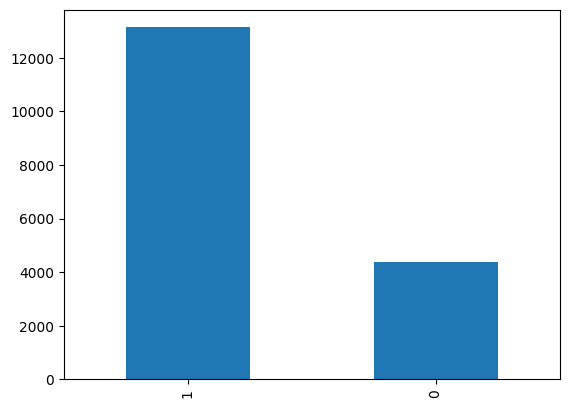

In [7]:
data.has_cactus.value_counts().plot(kind = 'bar')

In [17]:
!unzip -q /content/train.zip

In [8]:
data.isna().sum()

id            0
has_cactus    0
dtype: int64

In [9]:
img_path = np.random.choice(os.listdir('/content/train'),25,replace = False)

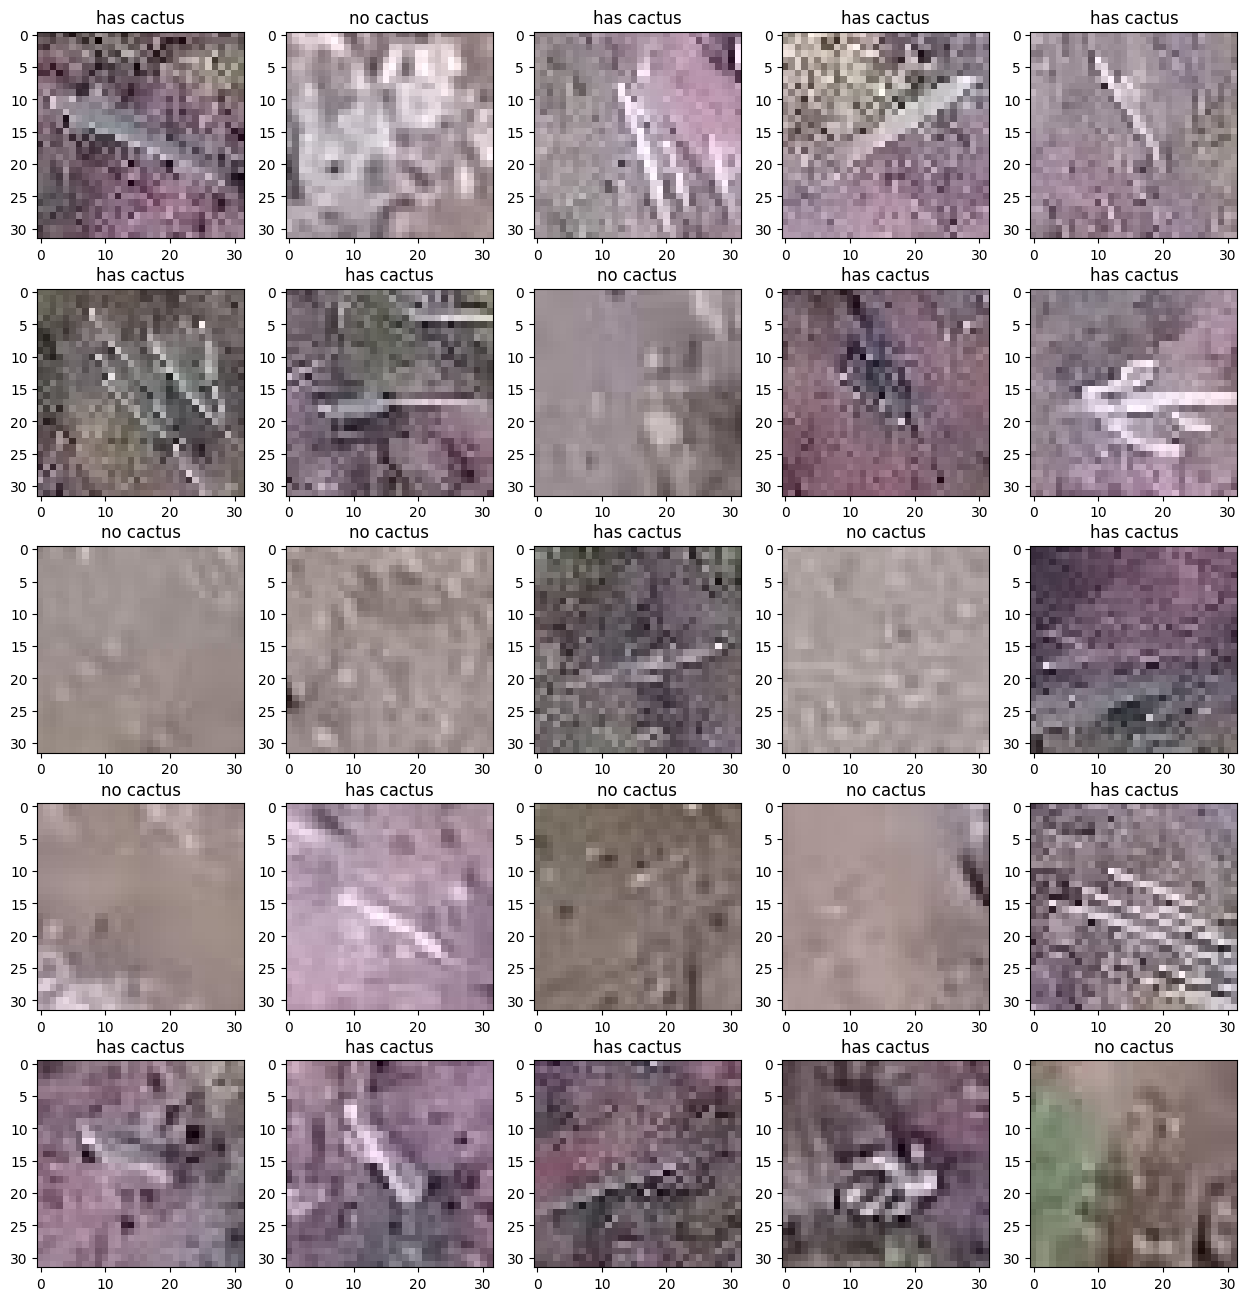

In [10]:
for idx,i in enumerate(img_path):
  img = cv2.imread(os.path.join('/content/train',i))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  tag = data[data['id']==i].has_cactus.values
  plt.subplot(5,5,idx+1)
  plt.imshow(img)
  plt.subplots_adjust(right = 2, top =2.7)
  if tag == 0:
    plt.title('no cactus')
  elif tag == 1:
    plt.title('has cactus')

In [51]:
length = []
width = []
for i in tqdm(os.listdir('/content/train')):
  img = cv2.imread(os.path.join('/content/train',i))
  length.append(img.shape[0])
  width.append(img.shape[1])

  0%|          | 0/17500 [00:00<?, ?it/s]

In [56]:
np.mean(length),np.mean(width)

(32.0, 32.0)

In [1]:
batch_size = 32

In [11]:
target = []
for i in data['has_cactus']:
  target.append([i])
data['target'] = target

  0%|          | 0/17500 [00:00<?, ?it/s]

In [12]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip = True,
                                                      rescale = 1/255.0,
                                                      validation_split = 0.1)

In [13]:
train = idg.flow_from_dataframe(data,directory = '/content/train',x_col = 'id',y_col = 'target',class_mode='categorical',
                                target_size = (32,32),batch_size =batch_size,subset = 'training')

Found 15750 validated image filenames belonging to 2 classes.


In [14]:
val = idg.flow_from_dataframe(data,directory = '/content/train',x_col = 'id',y_col = 'target',class_mode='categorical',
                                target_size = (32,32),batch_size =batch_size,subset = 'validation')

Found 1750 validated image filenames belonging to 2 classes.


In [27]:
#CNN Functional_model

##Input layer
input = tf.keras.layers.Input((32,32,3),name = 'Input')

##Chunk1
conv1 = tf.keras.layers.Conv2D(16,(3,3),strides = (1,1),padding = 'same',activation ='relu',name = 'Conv1')(input)
pool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides =(2,2),padding = 'valid',name = 'Pool1')(conv1)

##Chunk2
conv2 = tf.keras.layers.Conv2D(16,(3,3),strides = (1,1),padding = 'same',activation ='relu',name = 'Conv2')(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides =(2,2),padding = 'valid',name = 'Pool2')(conv2)

#Flatten
flatten = tf.keras.layers.Flatten(name = 'Flatten')(pool2)

#Hidden
hidden1 = tf.keras.layers.Dense(32,activation = 'relu',name = 'Hidden1')(flatten)
drop = tf.keras.layers.Dropout(0.3,name = 'dropout')(hidden1)
hidden2 = tf.keras.layers.Dense(16,activation = 'relu',name = 'Hidden2')(drop)

#Output Layer
output = tf.keras.layers.Dense(2, activation = 'softmax',name = 'Output')(hidden2)

In [28]:
final_model = tf.keras.Model(inputs = [input],outputs = [output])

In [29]:
final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 Conv2 (Conv2D)              (None, 16, 16, 16)        2320      
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 16)          0         
                                                                 
 Flatten (Flatten)           (None, 1024)              0         
                                                                 
 Hidden1 (Dense)             (None, 32)                3280

In [30]:
final_model.compile(optimizer = 'adam',loss = tf.keras.losses.binary_crossentropy,metrics = ['accuracy'])

In [31]:
final_model.fit(train,epochs =10,batch_size = batch_size,validation_data = val)

Epoch 1/10
493/493 [==============================] - 20s 38ms/step - loss: 0.2922 - accuracy: 0.8675 - val_loss: 0.1891 - val_accuracy: 0.9360
Epoch 2/10
493/493 [==============================] - 22s 45ms/step - loss: 0.1535 - accuracy: 0.9423 - val_loss: 0.1141 - val_accuracy: 0.9606
Epoch 3/10
493/493 [==============================] - 18s 37ms/step - loss: 0.1199 - accuracy: 0.9571 - val_loss: 0.1321 - val_accuracy: 0.9640
Epoch 4/10
493/493 [==============================] - 22s 44ms/step - loss: 0.1026 - accuracy: 0.9631 - val_loss: 0.0841 - val_accuracy: 0.9686
Epoch 5/10
493/493 [==============================] - 20s 40ms/step - loss: 0.0973 - accuracy: 0.9657 - val_loss: 0.1083 - val_accuracy: 0.9646
Epoch 6/10
493/493 [==============================] - 18s 37ms/step - loss: 0.0929 - accuracy: 0.9664 - val_loss: 0.0740 - val_accuracy: 0.9760
Epoch 7/10
493/493 [==============================] - 22s 44ms/step - loss: 0.0771 - accuracy: 0.9733 - val_loss: 0.0661 - val_accuracy:

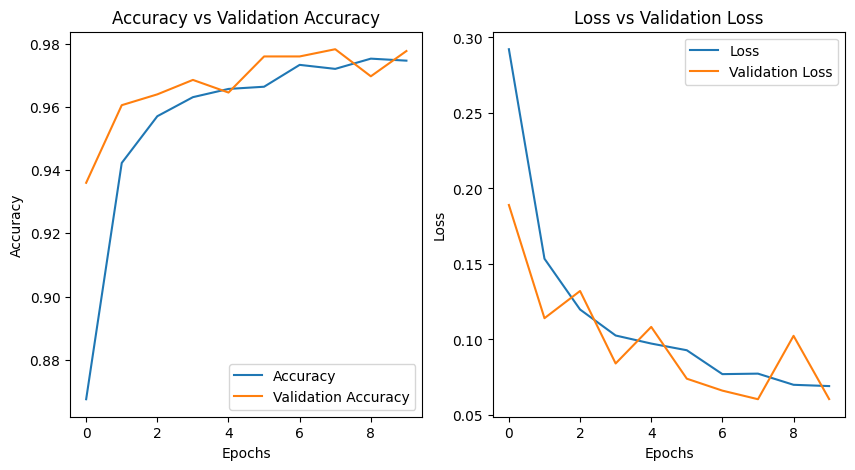

In [32]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(final_model.history.history['accuracy'],label = 'Accuracy')
plt.plot(final_model.history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(final_model.history.history['loss'],label = 'Loss')
plt.plot(final_model.history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()